In [1]:
import pandas as pd
import numpy as np

## Read Data

In [2]:
nyanglerbass_masked_df = pd.read_csv('/home/desbrium/Metis/FishingSpots/Data/nyanglerbass_masked.csv')

## Preprocessing

In [3]:
import spacy
from spacy import displacy
from spacy.symbols import amod
from spacy.matcher import PhraseMatcher
from spacy.tokens import Span

In [4]:
nlp = spacy.load("en_core_web_sm")

In [5]:
stop_string = '''
FISHING,FISH,JUST,KNOW,DON,LIKE,TIME,YEAR,THINK,GUYS,NEW,PEOPLE,LL,YEARS,ST,USE,FISHED,FISHING,COLOR,COM,HTTP,PHOTOBUCKET,WWW,JPG,
ALBUMS,SRC,IMG,HREF,_BLANK,BORDER,ALT,VIDEO,TARGET,PHP,MARTY,GUYS,LOL,DAY,TODAY,JOB,GUY,CONGRAT,LAUGH,LOOK,PIC,REPORT,
THANK,WAY,GREJOB,JOHN,MIKE,HOUR,MAN,JIM,HELP,NEED,QUESTION,QUICK,03,04,06,07,08,09,10,11,12,13,14,15,16,18,19,20,22,24,25,26,27,29,30,
1000,2008,2012,NY,1ST,ADVICE,REPAIR,WEEKEND,FINALLY,MAINE,WORK,SUNDAY,SUGGESTIONS,NYC,nybass,forum,LAKELAKE
'''

In [6]:
stop_list = stop_string.replace('\n', '').lower().split(',')

nlp.Defaults.stop_words |= {stop_word for stop_word in stop_list}

## Baseline Topic Modeling

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import NMF, LatentDirichletAllocation

In [8]:
def make_topics(docs, preprocessor, vectorizer, topic_modeler, print_n_words=15):
    """A very simple pipeline."""
    
    # Apply preprocessor, vectorizer, and topic modeler.
    if preprocessor is not None:
        docs = docs.apply(preprocessor)
    
    # Vectorize documents into a document-word matrix.
    doc_word_vectors = vectorizer.fit_transform(docs)
    
    # Fit the topic model.
    doc_topic_vectors = topic_modeler.fit_transform(doc_word_vectors)
    
    # Print the topics.
    vocab = vectorizer.get_feature_names()
    for idx, topic in enumerate(topic_modeler.components_):
        # Select the top 15 words in vocab for this topic.
        top_words = [vocab[i].upper() for i in topic.argsort()[:-print_n_words-1:-1]]
        print(f"Topic {idx}:\n", ", ".join(top_words), "\n")
    
    return doc_topic_vectors

#### Post Title Topics

In [9]:
docs = nyanglerbass_masked_df['Post_Title']
preprocessor = None
vectorizer = TfidfVectorizer(stop_words= nlp.Defaults.stop_words)
topic_modeler = NMF(7, random_state=10)

post_title_topics = make_topics(docs, preprocessor, vectorizer, topic_modeler);

/home/desbrium/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ve'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


Topic 0:
 LAKE, ONEIDA, GEORGE, CHAMPLAIN, ROCKLAND, SARATOGA, ERIE, ONTARIO, SILVER, GREENWOOD, CAYUGA, KEUKA, BLACK, RONKONKOMA, ROUND 

Topic 1:
 BASS, BIG, PRO, STRIPED, SEASON, NICE, SEA, SHOPS, BEST, BROWN, CAUGHT, BAIT, ICE, ISLAND, DECEMBER 

Topic 2:
 CROTON, RESERVOIR, FALLS, RES, MUSCOOT, BOAT, EAST, ICE, WEST, KENSICO, GREAT, TORONTO, BIG, WESTCHESTER, ASHOKAN 

Topic 3:
 TRIP, SOLO, SHORT, RES, ICE, SEASON, GREAT, MORNING, ISLANDS, DELAWARE, BOAT, KENSICO, RESERVOIR, NICE, OUTING 

Topic 4:
 RIVER, HUDSON, MOHAWK, SALMON, CROSS, DELAWARE, SMALLIES, STRIPERS, LAWRENCE, PECONIC, UPPER, SUSQUEHANNA, NIAGARA, SENECA, STEELHEAD 

Topic 5:
 GOOD, WATER, POND, LONG, GREAT, ISLAND, BAD, OUTING, CANDLEWOOD, COLD, WEATHER, NIGHT, DAYS, FRIDAY, TOUGH 

Topic 6:
 ROD, REEL, LINE, SPINNING, BEST, JIG, CRANKBAIT, FROG, LOOKING, BAIT, DROP, SHOT, CASTING, DAIWA, SHIMANO 



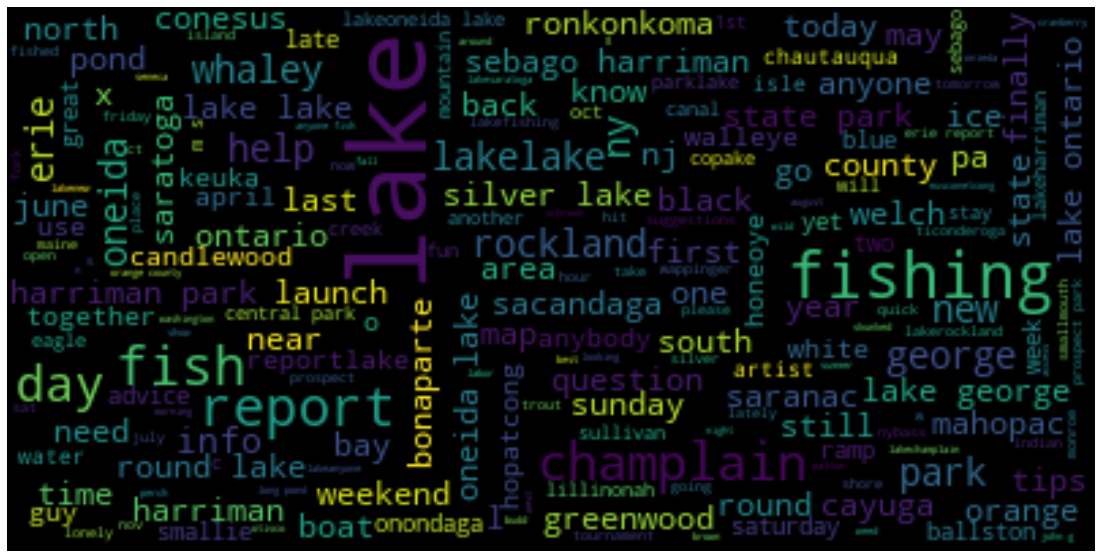

In [12]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def wordcloud_topic(topics, index, docs):
    words = ""
    
    for i, doc in enumerate(topics):
        main_topic = np.argsort(-doc)[0]
        if main_topic == index:
            words += docs[i]
            
    wordcloud = WordCloud(max_font_size=40).generate(words)
    plt.figure(figsize=(20,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.savefig('/home/desbrium/Metis/FishingSpots/Data/wordcloudtitle.svg')
    plt.show()
    
wordcloud_topic(post_title_topics, 0, docs)

In [29]:
nyanglerbass_masked_df[['Freshwater Locations', 'Bass Season', 'Reservoir Trip', 
                        'Croton_Reservoir', 'Rivers Runs', 'Water Conditions', 
                        'Rods And Attachments']] = pd.DataFrame(post_title_topics)

nyanglerbass_masked_df[['Post_Season','Freshwater Locations', 'Bass Season', 'Reservoir Trip', 
                        'Croton_Reservoir', 'Rivers Runs', 'Water Conditions', 
                        'Rods And Attachments']].groupby('Post_Season').mean()

,Freshwater Locations,Bass Season,Reservoir Trip,Croton_Reservoir,Rivers Runs,Water Conditions,Rods And Attachments
Post_Season,,,,,,,
Fall,0.008110,0.004360,0.003387,0.006111,0.005189,0.004248,0.003702
Spring,0.007614,0.005504,0.003805,0.003939,0.003703,0.004405,0.003826
Summer,0.010982,0.004480,0.003448,0.004098,0.003915,0.004418,0.003249
Winter,0.004185,0.005480,0.002515,0.001584,0.002604,0.002731,0.006908


In [60]:
docs = nyanglerbass_masked_df['Post_Title']
preprocessor = None
vectorizer = TfidfVectorizer(stop_words= nlp.Defaults.stop_words, ngram_range=(1,2))
topic_modeler = NMF(7, random_state=10)

post_title_topics2 = make_topics(docs, preprocessor, vectorizer, topic_modeler);

/home/desbrium/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['nyc', 've'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


Topic 0:
 LAKE, GEORGE, LAKE GEORGE, CHAMPLAIN, SARATOGA, LAKE CHAMPLAIN, ROCKLAND LAKE, ROCKLAND, SARATOGA LAKE, ERIE, LAKE ERIE, GREENWOOD, GREENWOOD LAKE, CAYUGA, SILVER 

Topic 1:
 BASS, BIG, BIG BASS, PRO, BASS PRO, STRIPED BASS, STRIPED, SEASON, BASS SEASON, SEA BASS, NICE, SEA, PRO SHOPS, SHOPS, NICE BASS 

Topic 2:
 CROTON, RESERVOIR, CROTON RESERVOIR, CROTON FALLS, FALLS, CROTON RES, RES, EAST, WEST, EAST CROTON, MUSCOOT, BOAT, GOOD, MID CROTON, WEST CROTON 

Topic 3:
 RIVER, HUDSON, MOHAWK, HUDSON RIVER, MOHAWK RIVER, SALMON, SALMON RIVER, CROSS, CROSS RIVER, STRIPERS, DELAWARE, DELAWARE RIVER, LAWRENCE, LAWRENCE RIVER, SMALLIES 

Topic 4:
 TRIP, SOLO, GOOD, ICE, SHORT, SOLO TRIP, RES, CANDLEWOOD, SHORT TRIP, POND, RESERVOIR, ISLAND, LONG, GREAT, SEASON 

Topic 5:
 ONEIDA, ONEIDA LAKE, LAKE ONEIDA, LAKE, GOOD, CUS, LAKE CUS, WALLEYE, LAKE OCT, OCT, SEASON, ONEIDA WEEK, LAKE SEASON, NOV, SMALLIES 

Topic 6:
 ROD, REEL, ROD REEL, LINE, SPINNING, JIG, BEST, GOOD, SPINNING ROD, S

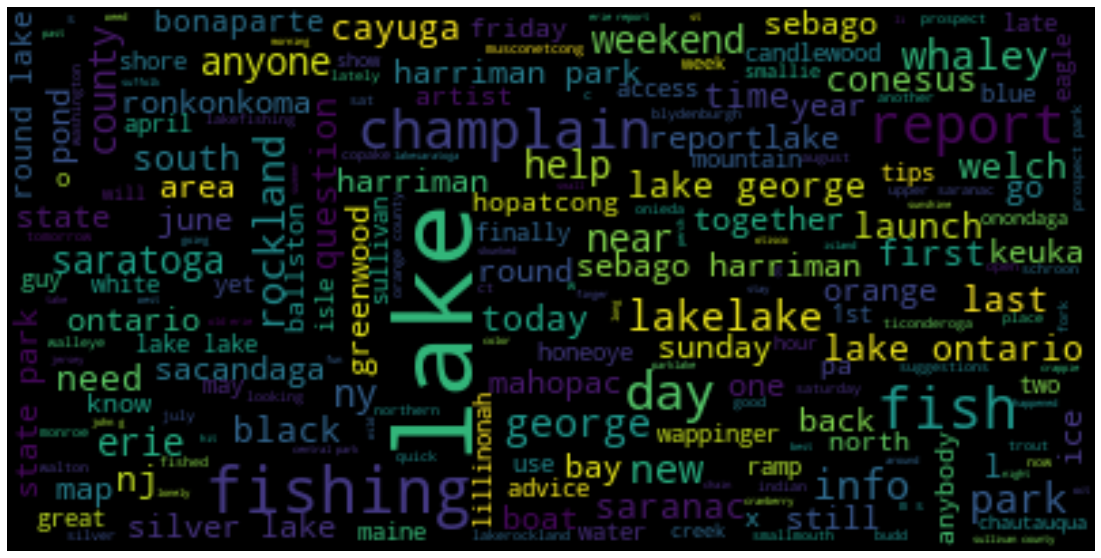

In [61]:
wordcloud_topic(post_title_topics2, 0, docs)

In [40]:
nyanglerbass_masked_df[['Freshwater Locations', 'Bass Season',
                        'Croton_Reservoir', 'Rivers Runs', 'Fishing Trip', 'Oneida Lake',
                        'Rods And Attachments']] = pd.DataFrame(post_title_topics2)

nyanglerbass_masked_df[['Post_Season','Freshwater Locations', 'Bass Season',
                        'Croton_Reservoir', 'Rivers Runs', 'Fishing Trip', 'Oneida Lake',
                        'Rods And Attachments']].groupby('Post_Season').mean()

,Freshwater Locations,Bass Season,Croton_Reservoir,Rivers Runs,Fishing Trip,Oneida Lake,Rods And Attachments
Post_Season,,,,,,,
Fall,0.006421,0.003309,0.004046,0.003998,0.004474,0.001778,0.002746
Spring,0.005968,0.004378,0.002268,0.002736,0.005040,0.001763,0.002771
Summer,0.008781,0.003500,0.002555,0.002893,0.004554,0.002186,0.002442
Winter,0.003299,0.004195,0.000615,0.001938,0.003322,0.000563,0.005144


#### Document 

In [62]:
docs = nyanglerbass_masked_df["Lemma_Post_Content"]
preprocessor = None
vectorizer = TfidfVectorizer(stop_words= nlp.Defaults.stop_words)
topic_modeler = NMF(7, random_state=10)

final_topics = make_topics(docs, preprocessor, vectorizer, topic_modeler);

/home/desbrium/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['nyc', 've'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


Topic 0:
 NICE, CATCH, GOOD, BIG, SMALLIE, BASS, LB, PICTURE, FUN, BEAUTIFUL, AWESOME, TRIP, BITE, POUND, START 

Topic 1:
 ROD, CROIX, ACTION, HEAVY, MEDIUM, LIGHT, MH, LOOMIS, BLANK, TIP, GUIDE, SPINNING, FAST, SERIES, BUY 

Topic 2:
 LAKE, BASS, CATCH, POND, GOOD, AREA, LAUNCH, PLACE, PARK, RIVER, BOAT, SMALL, VE, INFO, SHORE 

Topic 3:
 HOOK, BAIT, JIG, RIG, WORM, BASS, TUBE, FROG, CATCH, TRY, SENKO, PLASTIC, WEIGHT, LURE, THROW 

Topic 4:
 LINE, BRAID, FLUOROCARBON, KNOT, LB, LEADER, MONO, SPOOL, TEST, TIE, POWER, PRO, UNI, SPINNING, DIAMETER 

Topic 5:
 WATER, TEMP, WIND, DEEP, WEED, COLD, ICE, BITE, SHALLOW, WEATHER, WEEK, RAIN, START, FOOT, DEGREE 

Topic 6:
 REEL, SHIMANO, DAIWA, SPOOL, CURADO, BUY, BAITCASTER, PRICE, SPINNING, GEAR, CAST, BEARING, GOOD, LINE, QUANTUM 



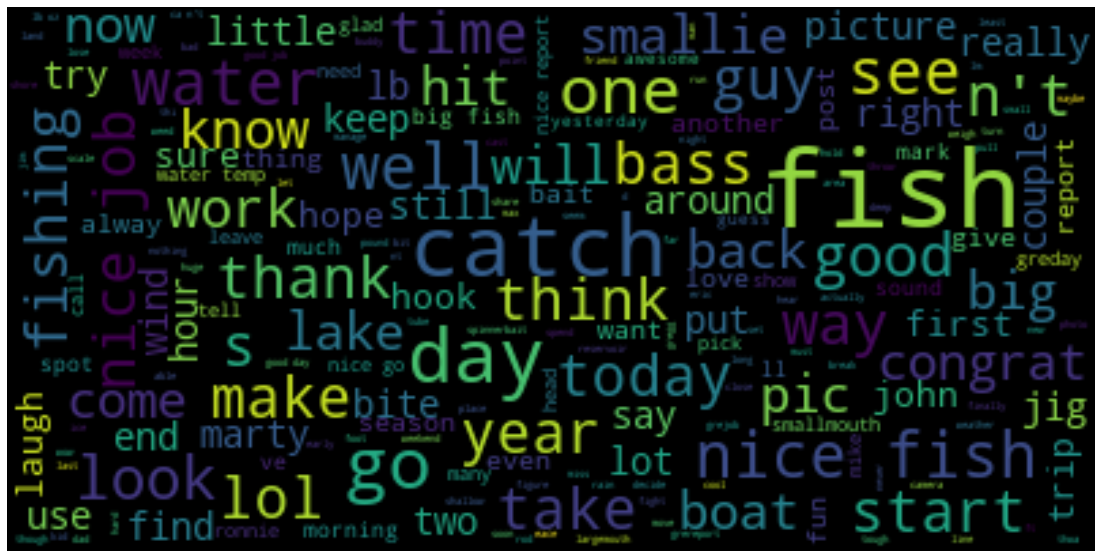

In [63]:
wordcloud_topic(final_topics, 0, docs)

In [43]:
nyanglerbass_masked_df[['Mood', 'Rods', 'Freshwater_Attributes', 
                        'Line Attachments', 'Lines', 'Weather Conditions', 
                        'Rods And Attachments']] = pd.DataFrame(final_topics)

nyanglerbass_masked_df[['Post_Season','Mood', 'Rods', 'Freshwater_Attributes', 
                        'Line Attachments', 'Lines', 'Weather Conditions', 
                        'Rods And Attachments']].groupby('Post_Season').mean()

,Mood,Rods,Freshwater_Attributes,Line Attachments,Lines,Weather Conditions,Rods And Attachments
Post_Season,,,,,,,
Fall,0.014612,0.006557,0.018806,0.014197,0.005023,0.013868,0.007745
Spring,0.014809,0.006495,0.017861,0.015257,0.006642,0.012854,0.007120
Summer,0.014465,0.005807,0.020805,0.016971,0.005720,0.012679,0.005821
Winter,0.008664,0.010564,0.016830,0.017750,0.008234,0.009671,0.012496


## Season Topic Modelling

In [44]:
spring_titles = nyanglerbass_masked_df[nyanglerbass_masked_df['Post_Season'] == 'Spring']['Post_Title']
summer_titles = nyanglerbass_masked_df[nyanglerbass_masked_df['Post_Season'] == 'Summer']['Post_Title']
fall_titles = nyanglerbass_masked_df[nyanglerbass_masked_df['Post_Season'] == 'Fall']['Post_Title']
winter_titles = nyanglerbass_masked_df[nyanglerbass_masked_df['Post_Season'] == 'Winter']['Post_Title']

spring_posts = nyanglerbass_masked_df[nyanglerbass_masked_df['Post_Season'] == 'Spring']['Lemma_Post_Content']
summer_posts = nyanglerbass_masked_df[nyanglerbass_masked_df['Post_Season'] == 'Summer']['Lemma_Post_Content']
fall_posts = nyanglerbass_masked_df[nyanglerbass_masked_df['Post_Season'] == 'Fall']['Lemma_Post_Content']
winter_posts = nyanglerbass_masked_df[nyanglerbass_masked_df['Post_Season'] == 'Winter']['Lemma_Post_Content']

In [48]:
print('Post Title Topics')
docs = spring_titles
preprocessor = None
vectorizer = TfidfVectorizer(stop_words= nlp.Defaults.stop_words)
topic_modeler = NMF(7, random_state=10)

make_topics(docs, preprocessor, vectorizer, topic_modeler);

print('Post Content Topics')
docs = spring_posts

make_topics(docs, preprocessor, vectorizer, topic_modeler);

Post Title Topics
Topic 0:
 LAKE, ONEIDA, SARATOGA, GEORGE, CHAMPLAIN, ERIE, ARTIST, ROCKLAND, BONAPARTE, SILVER, PARK, ONTARIO, LILLINONAH, HARRIMAN, WHITE 

Topic 1:
 BASS, BIG, SEASON, STRIPED, NICE, BROWN, PRO, TROUT, ROCKLAND, SHOPS, ICE, BEST, CAUGHT, EARLY, BIGGEST 

Topic 2:
 TRIP, SOLO, SEASON, SHORT, RES, HARRIMAN, MORNING, BOAT, EARLY, APRIL, MARCH, SPRING, LONG, 17, BIG 

Topic 3:
 GOOD, OUTING, BAD, FRIDAY, WEATHER, 17, BITE, GREAT, PB, START, NUMBERS, TED, SOLO, PRETTY, 2010 

Topic 4:
 RESERVOIR, CROTON, ICE, TORONTO, KENSICO, BOAT, MUSCOOT, TROUT, FALLS, NYC, DOG, EAST, WESTCHESTER, RES, WINDY 

Topic 5:
 RIVER, HUDSON, STRIPERS, CROSS, MOHAWK, LOWER, STRIPER, SALMON, SHORE, RES, SPRING, DELAWARE, PECONIC, POTOMAC, SMALLIES 

Topic 6:
 WATER, CANDLEWOOD, GREAT, COLD, TEMPS, ICE, OPEN, ROD, LEVELS, CHAMPLAIN, NICE, POND, LEVEL, TOPWATER, HIGH 

Post Content Topics


/home/desbrium/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['nyc', 've'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


Topic 0:
 NICE, SMALLIE, GOOD, CATCH, LB, JIG, BIG, WIND, BEAUTIFUL, GREDAY, AWESOME, PICTURE, WTG, OZ, BITE 

Topic 1:
 ROD, REEL, SPINNING, SHIMANO, DAIWA, BUY, LIGHT, CROIX, HEAVY, CAST, BAITCASTER, PRICE, MH, ACTION, MEDIUM 

Topic 2:
 LAKE, LAUNCH, GOOD, PARK, INFO, POND, PLACE, BOAT, AREA, SHORE, OPEN, MAP, ICE, ACCESS, NORTH 

Topic 3:
 HOOK, JIG, BAIT, RIG, WORM, FROG, SENKO, WEIGHT, TUBE, TRY, PLASTIC, HEAD, TRAILER, WEED, OZ 

Topic 4:
 LINE, BRAID, KNOT, FLUOROCARBON, SPOOL, LEADER, MONO, LB, REEL, TEST, TIE, UNI, SPINNING, PROBLEM, PRO 

Topic 5:
 WATER, TEMP, WIND, BED, SPAWN, RAIN, DEEP, WEEK, COLD, SHALLOW, WEATHER, BITE, WARM, DEGREE, START 

Topic 6:
 CATCH, BASS, BIG, PIKE, SEASON, CRAPPIE, GOOD, SMALL, POND, VE, POST, TROUT, PICKEREL, STRIPER, INCH 



/home/desbrium/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [53]:
print('Post Title Topics')
docs = summer_titles
preprocessor = None
vectorizer = TfidfVectorizer(stop_words= nlp.Defaults.stop_words)
topic_modeler = NMF(7, random_state=10)

make_topics(docs, preprocessor, vectorizer, topic_modeler);

print('Post Content Topics')
docs = summer_posts

make_topics(docs, preprocessor, vectorizer, topic_modeler);

Post Title Topics
Topic 0:
 LAKE, GEORGE, CHAMPLAIN, ROCKLAND, SARATOGA, GREENWOOD, ONTARIO, KEUKA, CAYUGA, BLACK, ROUND, WHALEY, ERIE, SILVER, WELCH 

Topic 1:
 BASS, BIG, SEA, BEST, SON, PRO, FROG, WALLEYE, PIKE, CATCH, WATER, ISLAND, PB, CAUGHT, SMALLMOUTH 

Topic 2:
 POND, LONG, ISLAND, FORGE, FORT, LOCAL, SMALL, LI, SANDY, NICE, MILL, STATEN, BROWN, WHITE, LAKES 

Topic 3:
 CROTON, RESERVOIR, GOOD, FALLS, NYC, EVENING, MUSCOOT, TOUGH, BOAT, WEST, AREA, ASHOKAN, WESTCHESTER, WATER, EAST 

Topic 4:
 TRIP, SOLO, RES, GOOD, NIGHT, SHORT, GREAT, MORNING, FLOAT, DELAWARE, ANNUAL, KENSICO, DECENT, OUTING, EVENING 

Topic 5:
 RIVER, MOHAWK, HUDSON, CROSS, DELAWARE, PECONIC, UPPER, NIAGARA, SMALLIES, INFO, LAWRENCE, AREA, 21, SUSQUEHANNA, SCHUYLERVILLE 

Topic 6:
 ONEIDA, LAKE, 17, GOOD, STAY, TIPS, OPENING, JULY, JUNE, REPORTS, PLACES, WEEK, SMALLIES, WEEKS, VACATION 

Post Content Topics


/home/desbrium/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['nyc', 've'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


Topic 0:
 WATER, WEED, DEEP, TEMP, WIND, BITE, JIG, FIND, GOOD, SHALLOW, EDGE, FOOT, START, RESERVOIR, DROP 

Topic 1:
 ROD, REEL, SHIMANO, CROIX, DAIWA, BUY, MEDIUM, PRICE, ACTION, LIGHT, SPINNING, HEAVY, MH, SERIES, FAST 

Topic 2:
 LAKE, BASS, POND, GOOD, CATCH, LAUNCH, AREA, PLACE, SHORE, RIVER, PARK, SMALL, BOAT, VE, INFO 

Topic 3:
 HOOK, BAIT, RIG, JIG, WORM, SENKO, CATCH, BASS, TUBE, WEIGHT, TRY, PLASTIC, LURE, THROW, VE 

Topic 4:
 NICE, CATCH, GOOD, BIG, BASS, SMALLIE, LB, PICTURE, TRIP, EACE, FUN, BITE, POUND, WTG, NIGHT 

Topic 5:
 LINE, BRAID, SPOOL, REEL, MONO, KNOT, LB, LEADER, FLUOROCARBON, TEST, CAST, PRO, SPINNING, POWER, TIE 

Topic 6:
 FROG, PAD, POND, HOOK, TOAD, BASS, SPRO, MISS, BILL, HIT, WEED, SNAGPROOF, THROW, SCUM, HORNY 



In [54]:
print('Post Title Topics')
docs = fall_titles
preprocessor = None
vectorizer = TfidfVectorizer(stop_words= nlp.Defaults.stop_words)
topic_modeler = NMF(7, random_state=10)

make_topics(docs, preprocessor, vectorizer, topic_modeler);

print('Post Content Topics')
docs = fall_posts

make_topics(docs, preprocessor, vectorizer, topic_modeler);

Post Title Topics
Topic 0:
 LAKE, ONEIDA, SARATOGA, ROCKLAND, GEORGE, CHAMPLAIN, WELCH, HARRIMAN, CAYUGA, PARK, RONKONKOMA, GREENWOOD, ROUND, BALLSTON, CONESUS 

Topic 1:
 CROTON, RESERVOIR, FALLS, RES, GREAT, WEST, EAST, MID, MARK, 17, 21, 23, SHORE, BIG, JIG 

Topic 2:
 RIVER, SALMON, MOHAWK, HUDSON, SMALLIES, LAWRENCE, CROSS, SENECA, DELAWARE, SUSQUEHANNA, 17, STEELHEAD, LOCK, NOV, BLACK 

Topic 3:
 BASS, BIG, SEA, STRIPED, PRO, SEASON, SHOPS, WINTER, BIGGEST, NOVEMBER, ISLAND, BLACK, POND, JIGS, STALKER 

Topic 4:
 TRIP, SOLO, GREAT, SHORT, MUSCOOT, RESERVOIR, ISLANDS, RES, AFTERNOON, BOAT, SATURDAY, OUTING, SEASON, TITICUS, KENSICO 

Topic 5:
 FALL, JIG, BITE, TROUT, BEST, WINTER, TOUGH, NICE, CHAMPLAIN, WATER, LATE, FRENZY, RUN, RESERVOIR, MUSKY 

Topic 6:
 GOOD, WATER, COLD, POND, ROD, CHAMPLAIN, TOUGH, LONG, ISLAND, REEL, MORNING, DAYS, DEEP, WEATHER, GREAT 

Post Content Topics


/home/desbrium/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['nyc', 've'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


Topic 0:
 BAIT, HOOK, JIG, RIG, BASS, CATCH, WORM, LURE, TUBE, LINE, PLASTIC, TRY, THROW, SENKO, LUR 

Topic 1:
 ROD, CROIX, BLANK, LIGHT, MEDIUM, GUIDE, KISTLER, HEAVY, LOOMIS, ACTION, MH, PRICE, BUY, SPINNING, TIP 

Topic 2:
 LAKE, BASS, GOOD, CATCH, POND, RIVER, AREA, LAUNCH, WATER, PLACE, BOAT, STATE, PARK, POST, BIG 

Topic 3:
 NICE, CATCH, GOOD, BIG, SMALLIE, BASS, LB, PICTURE, EACE, BEAUTIFUL, AWESOME, SEASON, WTG, PERCH, FUN 

Topic 4:
 ICE, COLD, WINTER, PERCH, OPEN, FREEZE, SNOW, HOLE, WEEK, SAFE, LAKE, WARM, WATER, CRAPPIE, SEASON 

Topic 5:
 REEL, LINE, SPOOL, BRAID, SHIMANO, DAIWA, CURADO, FLUOROCARBON, SPINNING, BEARING, BAITCASTER, MONO, LB, GEAR, CAST 

Topic 6:
 WATER, WIND, TEMP, DEEP, COLD, WEED, BITE, JIG, WEATHER, RONNIE, GOOD, START, SHALLOW, DEGREE, WEEK 



In [52]:
print('Post Title Topics')
docs = winter_titles
preprocessor = None
vectorizer = TfidfVectorizer(stop_words= nlp.Defaults.stop_words)
topic_modeler = NMF(7, random_state=10)

make_topics(docs, preprocessor, vectorizer, topic_modeler);

print('Post Content Topics')
docs = winter_posts

make_topics(docs, preprocessor, vectorizer, topic_modeler);

Post Title Topics
Topic 0:
 ICE, TRIP, NICE, SEASON, WAMPUS, HOPATCONG, REPORTS, CANDLEWOOD, GOOD, RESERVOIR, MUSCOOT, OUTING, UPSTATE, GLENMERE, 2010 

Topic 1:
 BASS, DECEMBER, PRO, CHRISTMAS, BIG, 2009, JANUARY, BAIT, FANTASY, SEMINAR, SHOPS, JIGS, BOARD, NYBASS, SEASON 

Topic 2:
 LAKE, CHAMPLAIN, ONEIDA, BLACK, INFO, RONKONKOMA, ONTARIO, GEORGE, TROUT, CANDLEWOOD, WHITE, SARANAC, BRANT, SILVER, ROCKLAND 

Topic 3:
 ROD, FROG, QUESTIONS, CASTING, SPINNING, REPAIRS, CRANK, GUIDE, BRAID, BAIT, COD, WRAP, TUBES, JERKBAIT, VS 

Topic 4:
 REEL, LINE, SPINNING, DAIWA, LOOKING, SHIMANO, DEAL, GOOD, GREAT, FAVORITE, BAITCASTER, SERVICE, SIZE, MAINTENANCE, REELS 

Topic 5:
 RIVER, SALMON, STEELHEAD, TRIP, DEC, FEB, CHRISTMAS, MOHAWK, JAN, LAWRENCE, WINTER, EVE, CT, HUDSON, DECEMBER 

Topic 6:
 RODS, KISTLER, SHIMANO, DAIWA, REELS, CASTING, CROIX, GLASS, PRO, CRANKBAIT, VS, FENWICK, LOOMIS, SERIES, POWELL 

Post Content Topics


/home/desbrium/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['nyc', 've'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


Topic 0:
 LAKE, BASS, GOOD, CATCH, WATER, AREA, BOAT, BIG, PLACE, FIND, RIVER, POND, VE, POST, TROUT 

Topic 1:
 ROD, CROIX, ACTION, HEAVY, MEDIUM, LIGHT, LOOMIS, MH, BLANK, FAST, TIP, GUIDE, SPINNING, GOOD, KISTLER 

Topic 2:
 JIG, HOOK, BAIT, WORM, RIG, TUBE, WEIGHT, HEAD, TRAILER, OZ, PLASTIC, TRY, BLACK, THROW, TAIL 

Topic 3:
 LINE, BRAID, FLUOROCARBON, LB, MONO, LEADER, KNOT, SPOOL, TEST, STRETCH, DIAMETER, CAST, TRY, POWER, SPINNING 

Topic 4:
 REEL, DAIWA, SHIMANO, SPOOL, CURADO, BUY, QUANTUM, BAITCASTER, PRICE, GEAR, CAST, SPINNING, GOOD, MODEL, BEARING 

Topic 5:
 NICE, CATCH, WATER, TEMP, GOOD, BASS, WIND, START, BIG, COLD, BITE, SMALLIE, WEATHER, HIT, LB 

Topic 6:
 ICE, OPEN, WATER, WEEK, LAKE, COLD, APRIL, SNOW, WARM, FREEZE, WINTER, MELT, FREE, WEATHER, HOLE 



## Visualizing

In [ ]:
# def plot_top_words(model, feature_names, n_top_words, title):
#     fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
#     axes = axes.flatten()
#     for topic_idx, topic in enumerate(model.components_):
#         top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
#         top_features = [feature_names[i] for i in top_features_ind]
#         weights = topic[top_features_ind]

#         ax = axes[topic_idx]
#         ax.barh(top_features, weights, height=0.7)
#         ax.set_title(f'Topic {topic_idx +1}',
#                      fontdict={'fontsize': 30})
#         ax.invert_yaxis()
#         ax.tick_params(axis='both', which='major', labelsize=20)
#         for i in 'top right left'.split():
#             ax.spines[i].set_visible(False)
#         fig.suptitle(title, fontsize=40)

#     plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
#     plt.show()

In [ ]:
# tf_feature_names = vectorizer.get_feature_names()
# plot_top_words(topic_modeler, tf_feature_names, 15, 'Topics in NMF model')

In [ ]:
# from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# import matplotlib.pyplot as plt
# % matplotlib inline

text = " ".join(post for post in nyanglerbass_masked_df["Post_Content"])
# Create stopword list:
stopwords = set(nlp.Defaults.stop_words)

# Generate a word cloud image
wordcloud = WordCloud(stopwords=nlp.Defaults.stop_words, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()